# Imports and Hyperparameters

In [62]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx
import plotly.io as pio
#from src.utils import is_function, is_operator, is_variable
import copy

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 30
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

pio.templates.default = "plotly_dark"

# DATA PARAMETERS
max_tree_depth = None                                               # maximum depth of binary (equation) trees
num_equation_samples = 6000                                        # number of equations to sample
max_num_input_variables = 1                                        # maximum number of input variables (x1, x2, ...)
max_num_constants = 1                                              # maximum number of constants (c1, c2, ...)
num_evaluation_samples = 50                                        # number of points to evaluate the entire equations at
inf_repacement = 1000



# TRAINING PARAMETERS
training_set_proportion = 0.8                           # proportion of data to use for training
num_epochs = 500                                       # number of epochs to train for
batch_size = 50                                         # batch size
learning_rate = 0.01
record = True
kl_weight = 0.001


# MODEL PARAMETERS
latent_dims = 4

is_function = lambda x: x in ["sin", "cos", "tan", "exp", "log", "sqrt", "abs", "acos","asin", "arcsin", "arccos"]
is_operator = lambda x : x in ["+", "-", "*", "/", "**", "max", "min"]
is_variable = lambda x : x in ["x_1"]
is_constant = lambda x : x in ["c_1", "c_0"]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

Requirements:
- one constant
- sample random numbers for constants
- prefix notation 
- same equation with different constants

Open Questions:
- What kind of padding should be used for constants? (In the case that the equation has no constant)
    - Use constants with excactly one constant
- If the x values are the same for every data point (from -1 to 1), then do we even need them for training?
    - We could always normalize the independent varaible

What it does:
- get unique symbols
- map indices to symboly and vice versa
- create data set from equations and values
- split into train and test sets
- create data loaders

[](./images/dataloader.png)

In [65]:
%reload_ext autoreload
from src.preprocessing import generate_dataset, preprocessing

# load or create dataset
try: 
    dataset = torch.load("./data/dataset_6000.pt")
except FileNotFoundError:
    dataset, max_len, unique_symbols = generate_dataset(num_equation_samples)
    torch.save(dataset, "./data/dataset_6000.pt")

train_loader, test_loader, test_size = preprocessing(
    dataset=dataset,
    batch_size=batch_size,
    training_set_proportion=training_set_proportion
)

equations = [dataset.decode_equation(x[0]) for x in dataset]
constants = [list(x[1].detach().numpy()) for x in dataset]
values = [list(x[2].detach().numpy()) for x in dataset] 
all_symbols = [item for sublist in equations for item in sublist]
unique_symbols = sorted(list(set(all_symbols)))
max_len = len(equations[0])

In [27]:
%reload_ext autoreload
from src.evaluation import plot_functions

fig = plot_functions(
    equations=equations[:20],
    constants=constants[:20],
    values=values[:20],
    is_function=is_function,
    is_operator=is_operator,
)

In [3]:
from src.models import AutoencoderEquations
autoencoder = AutoencoderEquations(latent_dims=latent_dims, vocab_size=len(unique_symbols))
print(autoencoder)

AttributeError: module 'torch.nn' has no attribute 'softmax'

# Model Training

## VAE ECV

In [64]:
%reload_ext autoreload
from src.training import training_VAE

autoencoder_equations, train_losses, test_losses, correlations_cor, correlations_dis, x_batches, x_hat_batches, df_results = training_VAE(train_loader, test_loader, latent_dims, unique_symbols, num_epochs, learning_rate, test_size, kl_weight)
best_correlation_dis = df_results['correlation_dis']
best_correlation_cor = df_results['correlation_cor']

Epoch 1/500, Training Loss: 3.785226345062256, Test Loss: 3.87107261021932, Correlation_cor: -0.05936744436621666, Correlation_dis: -0.0012362798443064094
Epoch 2/500, Training Loss: 3.3418750762939453, Test Loss: 3.4391473134358725, Correlation_cor: 0.01205846294760704, Correlation_dis: 0.13476894795894623
Epoch 3/500, Training Loss: 2.969029664993286, Test Loss: 3.289598206679026, Correlation_cor: -0.007602328900247812, Correlation_dis: 0.2454768568277359
Epoch 4/500, Training Loss: 3.4842004776000977, Test Loss: 3.1740578015645347, Correlation_cor: 0.021662602201104164, Correlation_dis: 0.3573828935623169
Epoch 5/500, Training Loss: 2.680142402648926, Test Loss: 3.066327691078186, Correlation_cor: -0.036055583506822586, Correlation_dis: 0.3305106461048126
Epoch 6/500, Training Loss: 2.5455331802368164, Test Loss: 3.034788409868876, Correlation_cor: -0.035785578191280365, Correlation_dis: 0.2937411069869995
Epoch 7/500, Training Loss: 2.404247283935547, Test Loss: 2.8093045949935913,

## Autoencoder ECV

In [66]:
from src.training import training_AE
from torchviz import make_dot
autoencoder_equations, train_losses, test_losses, correlations_cor, correlations_dis, x_batches, x_hat_batches, df_results = training_AE(train_loader, test_loader, latent_dims, unique_symbols, num_epochs, learning_rate, test_size)
best_correlation_dis = df_results['correlation_dis']
best_correlation_cor = df_results['correlation_cor']


Epoch 1/500, Training Loss: 1.4076690673828125, Test Loss: 1.2569012309114138, Correlation_cor: -0.06180192530155182, Correlation_dis: 0.42651599645614624
Epoch 2/500, Training Loss: 1.0696449279785156, Test Loss: 1.1473532629509766, Correlation_cor: -0.06711620837450027, Correlation_dis: 0.45473942160606384
Epoch 3/500, Training Loss: 1.4400326013565063, Test Loss: 1.1605226285755634, Correlation_cor: -0.06856408715248108, Correlation_dis: 0.4407650828361511
Epoch 4/500, Training Loss: 1.2077196836471558, Test Loss: 1.104086770117283, Correlation_cor: -0.0622914582490921, Correlation_dis: 0.47666215896606445
Epoch 5/500, Training Loss: 1.5523948669433594, Test Loss: 1.003704354291161, Correlation_cor: -0.06074702739715576, Correlation_dis: 0.4975847601890564
Epoch 6/500, Training Loss: 0.7282503247261047, Test Loss: 1.0738926115135352, Correlation_cor: -0.06488195061683655, Correlation_dis: 0.4833427369594574
Epoch 7/500, Training Loss: 0.9906415939331055, Test Loss: 0.971246266613404

## Loss curves

correlation distance of last epoch: 0.42112988233566284
correlation correlation of last epoch: -0.05389237403869629


KeyError: 'test_reconstruction_loss'

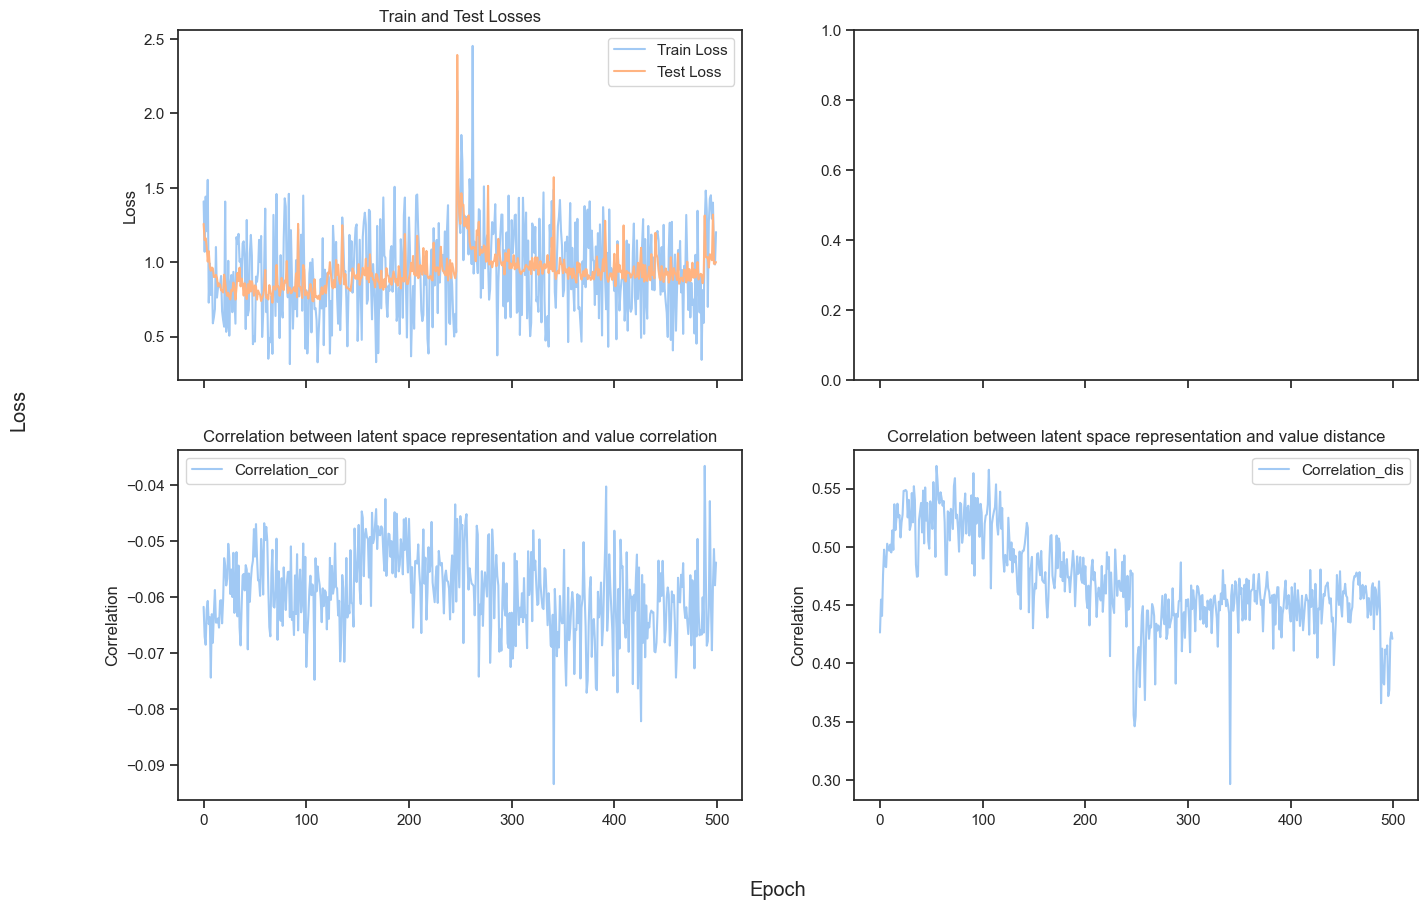

In [67]:
from src.utils import plot_losses
print(f"correlation distance of last epoch: {best_correlation_dis}")
print(f"correlation correlation of last epoch: {best_correlation_cor}")
plot_losses(
    train_losses,
    test_losses,
    correlation_cor=correlations_cor,
    correlation_dis=correlations_dis,
    df = df_results
)
last_correlations_cor = np.sum(correlations_cor[-10:]) / 10
last_correlations_dis = np.sum(correlations_dis[-10:]) / 10
print(f"Last 10 epochs average correlation: {last_correlations_cor}")
print(f"Last 10 epochs average correlation: {last_correlations_dis}")

# Evaluation

Visualization:
- get the latent space of 2 random equations
- plot them in red and blue (as vectors)
- plot 3 interpolations between them (in different shades of violet)
- decode the values of the interpolation and show their equations on hower




In [68]:
%reload_ext autoreload
from src.evaluation import evaluation_ec
from src.evaluation import get_latent_representation
from equation_tree.util.conversions import prefix_to_infix
from src.evaluation import get_interpolated_df

results, x_batches_p, x_hat_batches_p, x_constants_p, x_hat_constants_p = evaluation_ec(
            kind='AE',
            x_batches=x_batches,
            x_hat_batches=x_hat_batches,
            equation_tree_dataset=dataset,
            max_len=max_len,)

latent_space_representation, x_decoded, test_values, = get_latent_representation(
    model=autoencoder_equations,
    device=device,
    test_dataloader=test_loader,
    results=results,
    x_batches_p=x_batches_p,
    x_hat_batches_p=x_hat_batches_p,
    equation_tree_dataset=dataset,
    num_interpolations=5
)

# interpolated_df, z_list = get_interpolated_df(
#     kind='AE',
#     model=autoencoder_equations,
#     equation_tree_dataset=dataset,
#     latent_space_representation=latent_space_representation,
#     equation_1=results["rand_idx1"],
#     equation_2=results["rand_idx2"],
#     c_1=float(results["original constants rand_idx1"]),
#     c_2=float(results["original constants rand_idx2"]),
#     num_interpolations = 5
# )

results

{'rand_idx1': 5925,
 'rand_idx2': 4517,
 'original rand_idx1': array([ 3, 25,  0, 15, 25, 16]),
 'reconstructed rand_idx1': '[ 1 25  0 22 25 16]',
 'x_decoded1': ['-', 'x_1', '*', 'asin', 'x_1', 'c_1'],
 'x_decoded2': ['tan', '+', 'c_1', 'exp', 'exp', 'x_1'],
 'x_hat_decoded': ['**', 'x_1', '*', 'sin', 'x_1', 'c_1'],
 'original constants rand_idx1': array(0.2965524, dtype=float32),
 'original constants rand_idx2': array(0.8197466, dtype=float32),
 'reconstructed constants rand_idx1': array([0.5870337], dtype=float32),
 'correctly recovered individual signs': '62669 out of 72000',
 'accuracy (individual)': 0.8704027777777777,
 'correctly recovered equations': '5583 out of 12000',
 'accuracy (equations)': 0.46525,
 'average distance constants': 0.1821097615559896,
 'average mse constants': 0.0559610341389974}



Correlation
- Calculate distance matrix for values of the equations 
- calculate distance matrix of the latent space representation
- create correleation matrix of the two

In [69]:
%reload_ext autoreload
from src.evaluation import get_correlation_coefficient
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

is_function = lambda x: x in ["sin", "cos", "tan", "exp", "log", "sqrt", "abs", "acos","asin", "arcsin", "arccos"]
is_operator = lambda x : x in ["+", "-", "*", "/", "**", "max", "min"]
is_variable = lambda x : x in ["x_1"]
is_constant = lambda x : x in ["c_1", "c_0"]

correlation_cor, correlation_dis, distance_matrix_lat, distance_matrix_values, df, test_values_det, dm_values, distance_df_values = get_correlation_coefficient(
    latent_space_representation=latent_space_representation, 
    x_decoded=x_decoded, 
    is_function=is_function, 
    is_operator=is_operator, 
    x_constants_p=x_constants_p, 
    test_values=test_values,
    dataset=dataset,
)





/Users/lisa/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning:

invalid value encountered in reduce

/Users/lisa/Code/CompNeuro_Autoencoder/src/evaluation.py:356: RuntimeWarning:

invalid value encountered in subtract

/Users/lisa/Code/CompNeuro_Autoencoder/src/evaluation.py:359: RuntimeWarning:

invalid value encountered in subtract



In [ ]:
fig = px.imshow([[1, correlation_cor ], 
                 [correlation_cor, 1]], 
                 x = ["Latent Space", "Function Correlation"], 
                 y = ["Latent Space", "Function Correlation"], 
                 color_continuous_scale='RdBu', 
                 title="Correlation Matrix")
fig.update_xaxes(side="top")
fig.show()
print(f"Correlation between Latent Space and Function correlation: {correlation_cor}")
fig = px.imshow([[1, correlation_dis ], 
                 [correlation_dis, 1]], 
                 x = ["Latent Space", "Function Correlation"], 
                 y = ["Latent Space", "Function Correlation"], 
                 color_continuous_scale='RdBu', 
                 title="Correlation Matrix")
fig.update_xaxes(side="top")
fig.show()
print(f"Correlation between Latent Space and Function correlation: {correlation_dis}")

## Visualizations

In [15]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

l = 20
fig = go.Figure(
    data=go.Heatmap(
        z=distance_matrix_lat[:l][:l],
        x=df["Category"][:l],
        y=df["Category"][:l],
        colorscale="Viridis",
    ),
    layout=go.Layout(
        title="Latent Space distance matrix",
        xaxis=dict(title="Equation"),
        yaxis=dict(title="Equation"),
    ),
)
fig.update_layout(width=800, height=800)
fig.show()

fig = go.Figure(
    data=go.Heatmap(
        z=distance_matrix_values[:l][:l],
        x=df["Category"][:l],
        y=df["Category"][:l],
        colorscale="Viridis",
    ),
    layout=go.Layout(
        title="Values distance matrix",
        xaxis=dict(title="Equation"),
        yaxis=dict(title="Equation"),
    ),
)
# fig.update_traces(colorbar_dtick="log")
fig.update_layout(width=800, height=800)
fig.show()

### Network appraoch

Currently not used!!

In [24]:
# Rank Values
neighbours = np.zeros((len(distance_matrix_values)))
dm = np.array(distance_matrix_values)
# print(dm)
# for i in range(len(distance_matrix_values)):

# print(np.argmin(dm[i], axis=0))
from collections import defaultdict

graph = defaultdict(list)
sorted = []
for reference_point in range(len(distance_matrix_values)):
    # Assuming the distance matrix is symmetric (same distance[i][j] = distance[j][i])
    num_points = dm.shape[0]

    # Create a list to store distances and indices
    distances = [
        (dm[reference_point][i], i) for i in range(num_points) if i != reference_point
    ]

    # Sort distances based on the first element (distance)
    distances.sort(key=lambda x: x[0])

    # Extract sorted indices
    sorted_indices = [reference_point] + [index for _, index in distances]
    graph[df["Category"][reference_point]] = [
        df["Category"][i] for _, i in distances[:3]
    ]
    sorted.append(distances)


# definition of function
def addEdge(graph, u, v):
    graph[u].append(v)


edges = []


def generate_edges(graph):
    # for each node in graph
    for node in graph:
        # for each neighbour node of a single node
        for neighbour in graph[node]:
            # if edge exists then append
            edges.append((node, neighbour))
    return edges


# for x in graph.keys():
#   for y in graph[x]:
#      addEdge(graph,x,y)

In [25]:
import networkx as nx

G = nx.Graph()

for i in range(len(distance_matrix_values)):
    G.add_node(df["Category"][i])

edges = generate_edges(graph)
for edge in edges:
    index_node = df.index[df["Category"] == edge[0]].tolist()[0]
    index_neighbour = df.index[df["Category"] == edge[1]].tolist()[0]
    G.add_edge(
        edge[0], edge[1], weight=distance_matrix_values[index_node][index_neighbour]
    )

In [26]:
import networkx as nx
import plotly.graph_objects as go

# TODO: for loop to add each node and its hovertext

# Convert networkx graph to plotly figure
pos = nx.spring_layout(G)  # positions for all nodes
edge_x_start = []
edge_y_start = []
edge_x_end = []
edge_y_end = []

edges_names = []

for edge in G.edges():
    edges_names.append((edge[0], edge[1]))
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x_start.append(x0)
    edge_y_start.append(y0)
    edge_x_end.append(x1)
    edge_y_end.append(y1)

print(edges_names[0])
edge_traces = []
for i, (x_start, y_start, x_end, y_end) in enumerate(
    zip(edge_x_start, edge_y_start, edge_x_end, edge_y_end)
):
    edge_trace = go.Scatter(
        x=[x_start, x_end],
        y=[y_start, y_end],
        hoverinfo="text",
        name=edges_names[i][0],
        mode="lines",
    )
    edge_traces.append(edge_trace)

node_x = []
node_y = []
node_names = []

for node in G.nodes():
    node_names.append(node)
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_traces = []
for i, (x, y) in enumerate(zip(node_x, node_y)):
    node_name = node_names[i]
    connections = graph[node_name]
    real_distances = ""
    lat_distances = ""
    # get index of node in df['Category']
    index_node = df.index[df["Category"] == node_name].tolist()[0]

    for connection in connections:
        index_connection = df.index[df["Category"] == connection].tolist()[0]
        real_distances += f"<br>Real Distance to {connection}: <b>{str(distance_matrix_values[index_node][index_connection])}</b>"
        lat_distances += f"<br>Latent Space Distance to {connection}: {str(distance_matrix_lat[index_node][index_connection])}"
    node_trace = go.Scatter(
        x=[x],
        y=[y],
        mode="markers+text",
        hoverinfo="text",
        hovertext=node_names[i] + real_distances + lat_distances,
        textposition="bottom center",
        name=node_names[i],
    )
    node_traces.append(node_trace)

data = edge_traces + node_traces
fig = go.Figure(
    data=data,
    layout=go.Layout(
        title="<br>Network graph made with Plotly",
        titlefont_size=16,
        showlegend=True,
        annotations=[
            dict(showarrow=True, xref="paper", yref="paper", x=0.005, y=-0.002)
        ],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    ),
)

fig.show()

('(0.15+x_1)', '(abs(x_1)**0.82)')


In [27]:
# shortest_path = G.shortest_path('asin((0.82*sin(abs(x_1))))', 'max(exp(x_1),x_1)')

path = nx.all_pairs_shortest_path(G)
path = dict(path)


def nearest_neighbor_tsp(graph):
    # Randomly pick a starting node
    start_node = random.choice(list(graph.nodes))
    current_node = start_node
    unvisited_nodes = set(graph.nodes)
    unvisited_nodes.remove(current_node)

    # List to store the path
    path = [current_node]

    while unvisited_nodes:
        # Find the nearest unvisited node
        # print(graph[current_node])
        # print([w for neighbours in graph[current_node].values() for w in neighbours.values()])
        nearest_neighbor = np.argmin(
            [
                w
                for neighbours in graph[current_node].values()
                for w in neighbours.values()
            ]
        )
        # Update current node and path
        current_node = list(graph[current_node])[nearest_neighbor]
        try:
            unvisited_nodes.remove(current_node)
        except KeyError:
            print("Key not found")
        path.append(current_node)

    # Add the starting node to complete the cycle
    path.append(start_node)

    return path

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Sample data
x = df["x"][:5]
y = df["y"][:5]
z = df["z"][:5]

# Calculate distances between points
distances = []
for i in range(len(x)):
    row = []
    for j in range(len(x)):
        dist = np.sqrt((x[j] - x[i]) ** 2 + (y[j] - y[i]) ** 2 + (z[j] - z[i]) ** 2)
        row.append(dist)
    distances.append(row)

# Create hover text
hover_text = []
for i in range(len(x)):
    text = ""
    for j in range(len(x)):
        if i != j:
            text += f"Distance to {j}: {distances[i][j]:.2f}<br>"
    hover_text.append(text)

data = []
for i in range(5):
    data_point = go.Scatter3d(
        x=[x[i]],
        y=[y[i]],
        z=[z[i]],
        hoverinfo="x+y+z+text",
        text=hover_text[i],
        name=f"{i}: {str(interpolated_df['Category'][i])}",
    )
    data.append(data_point)

# Create scatter plot
fig = go.Figure(data=data)

# Update layout
fig.update_layout(
    autosize=True,
    height=800,
    title="Distance Between Points on Hover",
    xaxis=dict(title="X-axis"),
    yaxis=dict(title="Y-axis"),
    hovermode="closest",
)
plot(
    fig,
    filename="distance.html",
    auto_open=False,
    image="png",
)
fig.show()

### Visualization of Latent Space

In [30]:
from plotly.offline import plot

# TODO: show distances in hovertext
fig = px.scatter_3d(
    df,
    x="x",
    y="y",
    z="z",
    color="Category",
    hover_data=["Category"],
    title="Latent Space Representation",
    size_max=0.1,
)
plot(fig, filename="latent_space.html", auto_open=False, image="png")
fig.show()

In [70]:
df.to_csv("results/ae_latent_space.csv")

<Axes: xlabel='z', ylabel='y'>

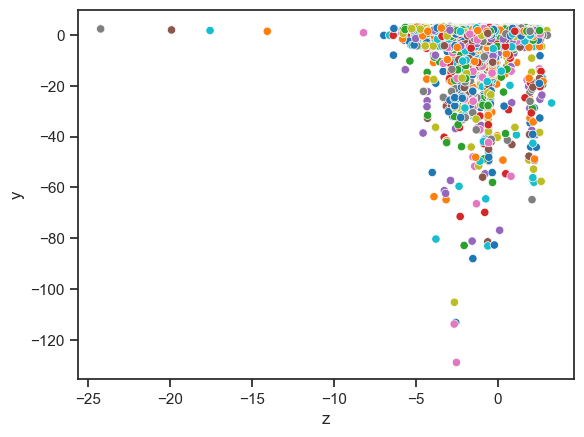

In [80]:
from colour import Color
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(df, x="z", y="y",hue='Category', legend=False, palette="tab10")

In [81]:
df_vae = pd.read_csv("results/vae_latent_space.csv")

<Axes: xlabel='z', ylabel='y'>

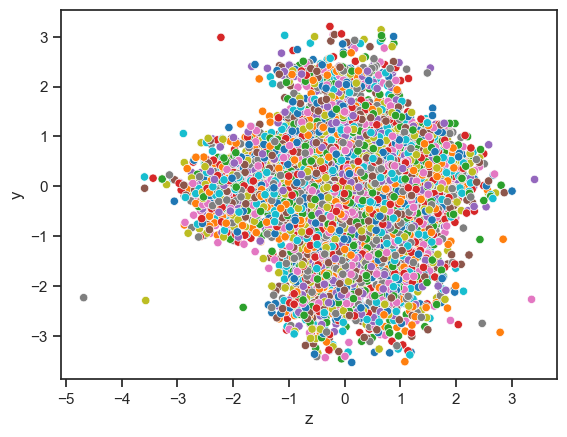

In [82]:
sns.scatterplot(df_vae, x="z", y="y",hue='Category', legend=False, palette="tab10")

In [28]:
from src.evaluation import plot_latent_vectors

# TODO: add distances to hovertext
plot_latent_vectors(
    z_list, interpolated_df, results, distance_matrix_lat, distance_matrix_values
)

### Plot Interpolations

In [4]:

from src.evaluation import plot_interpolations, generate_values


for i in range(5):
    rand_idx1 = random.randint(0, len(x_batches_p))
    rand_idx2 = random.randint(0, len(x_batches_p))
    df, _ = get_interpolated_df(
        kind="AE",
        model=autoencoder_equations,
        equation_tree_dataset=dataset,
        latent_space_representation=latent_space_representation,
        equation_1=rand_idx1,
        equation_2=rand_idx2,
        c_1=1.5,
        c_2=0.5,
        num_interpolations=20,
    )
    if len(df.values)> 0:
        plot_interpolations(df)




NameError: name 'random' is not defined

In [2]:

sin = 'sin(x_1*c_1)'
cos = 'cos(x_1*c_1)'
x = 'x_1'
constants = [10,10,10]
sin_values = generate_values(equation=sin, constant=constants[0])
cos_values = generate_values(equation=cos, constant=constants[1])
x_values = generate_values(equation=x, constant=constants[2])

#print(f"The two original functions ({sin} and ({cos})) have a correlation of {np.corrcoef(sin_values[1], cos_values[1])[0][1]}, a covariance of {np.cov(sin_values[1], cos_values[1])[0][1]} and a distance of {np.linalg.norm(np.array(sin_values[1]) - np.array(cos_values[1], ), ord=1)/25}")
#print(f"The two original functions ({sin} and ({x})) have a correlation of {np.corrcoef(sin_values[1], x_values[1])[0][1]}, a covariance of {np.cov(sin_values[1], x_values[1])[0][1]} and a distance of {np.linalg.norm(np.array(sin_values[1]) - np.array(x_values[1], ), ord=1)/25}")

df_try ={
    'functions': ['sin cos', 'x sin'],
    'correlation': [np.corrcoef(sin_values[1], cos_values[1])[0][1], np.corrcoef(sin_values[1], x_values[1])[0][1]],
    'covariance': [np.cov(sin_values[1], cos_values[1])[0][1], np.cov(sin_values[1], x_values[1])[0][1]],
    'area between curves': [np.linalg.norm(np.array(sin_values[1]) - np.array(cos_values[1], ), ord=1)/25, np.linalg.norm(np.array(sin_values[1]) - np.array(x_values[1], ), ord=1)/25], 
    'cosine similarity': [np.dot(sin_values[1], cos_values[1])/(np.linalg.norm(sin_values[1])*np.linalg.norm(cos_values[1])), np.dot(sin_values[1], x_values[1])/(np.linalg.norm(sin_values[1])*np.linalg.norm(x_values[1]))]

}
df_try = pd.DataFrame(df_try)
print(df_try)
fig = plot_functions([['sin', '*', 'x_1', 'c_1'],['cos', '*', 'x_1', 'c_1'], ['x_1']], [sin_values, cos_values, x_values], constants=constants, is_function=is_function, is_operator=is_operator)

NameError: name 'generate_values' is not defined

In [1]:
equation_1 = 'x_1*c_1'
equation_2 = 'x_1*c_1'
df, _ = get_interpolated_df(
    kind="AE",
    model=autoencoder_equations,
    equation_tree_dataset=dataset,
    latent_space_representation=latent_space_representation,
    equation_1=equation_1,
    equation_2=equation_2,
    c_1=-1.0,
    c_2=1.0,
    num_interpolations=20,
    assignment=(is_function, is_operator, is_variable, is_constant)
)
if len(df.values)> 0:
    plot_interpolations(df)

NameError: name 'get_interpolated_df' is not defined

In [31]:
cs = [[float(c)] for c in x_constants_p]
fig = plot_functions(
    equations=[results["x_decoded1"], list(results["x_decoded2"])],
    constants=[cs[results["rand_idx1"]], cs[results["rand_idx2"]]],
    values=[
        test_values_det[results["rand_idx1"]],
        test_values_det[results["rand_idx2"]],
    ],
    is_function=is_function,
    is_operator=is_operator,
)

## Random Embedding

In [35]:
from src.evaluation import random_embedding

random_embedding('AE', autoencoder_equations, dataset, latent_dims, (is_function, is_operator, is_variable, is_constant))

/Users/lisa/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/Users/lisa/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

invalid value encountered in log



Failed to convert ['**', '+', 'x_1', 'min', 'c_1', 'x_1', '**', '+', 'x_1', 'min', 'c_1', 'x_1'] to infix
Failed to convert ['/', '-', 'x_1', '*', 'x_1', 'x_1', '/', '-', 'x_1', '*', 'x_1', 'x_1'] to infix
Failed to convert ['min', '-', 'x_1', 'min', 'c_1', 'x_1', 'min', '-', 'x_1', 'min', 'c_1', 'x_1'] to infix
Failed to convert ['**', '-', 'x_1', 'min', 'c_1', 'x_1', '**', '-', 'x_1', 'min', 'c_1', 'x_1'] to infix
Failed to convert ['**', '-', 'x_1', '*', 'c_1', 'x_1', '**', '-', 'x_1', '*', 'c_1', 'x_1'] to infix
Failed to convert ['**', '*', 'c_1', 'min', 'c_1', 'x_1', '**', '*', 'c_1', 'min', 'c_1', 'x_1'] to infix
Failed to create tree: ['max', '-', 'x_1', 'asin', '<PAD>', 'x_1', 'max', '-', 'x_1', 'asin', '<PAD>', 'x_1']
Failed to create tree: ['max', '-', 'c_1', 'asin', '<PAD>', 'x_1', 'max', '-', 'c_1', 'asin', '<PAD>', 'x_1']
Failed to create tree: ['max', '+', 'c_1', 'c_1', '<PAD>', 'x_1', 'max', '+', 'c_1', 'c_1', '<PAD>', 'x_1']
Failed to convert ['**', '-', 'x_1', 'min', 

<lambdifygenerated-479>:2: RuntimeWarning:

divide by zero encountered in log

/Users/lisa/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

invalid value encountered in sqrt



Failed to convert ['**', '*', 'x_1', 'min', 'x_1', 'x_1', '**', '*', 'x_1', 'min', 'x_1', 'x_1'] to infix
Failed to convert ['max', '+', 'x_1', 'min', 'c_1', 'x_1', 'max', '+', 'x_1', 'min', 'c_1', 'x_1'] to infix
Failed to convert ['min', '-', 'x_1', '**', 'c_1', 'x_1', 'min', '-', 'x_1', '**', 'c_1', 'x_1'] to infix
Failed to create tree: ['log', '-', 'x_1', 'min', '<PAD>', 'x_1', 'log', '-', 'x_1', 'min', '<PAD>', 'x_1']
Failed to convert ['**', '-', 'x_1', 'min', 'c_1', 'x_1', '**', '-', 'x_1', 'min', 'c_1', 'x_1'] to infix
Failed to convert ['**', '-', 'x_1', 'min', 'c_1', 'x_1', '**', '-', 'x_1', 'min', 'c_1', 'x_1'] to infix
Failed to convert ['min', '-', 'x_1', 'min', 'c_1', 'x_1', 'min', '-', 'x_1', 'min', 'c_1', 'x_1'] to infix
Failed to create tree: ['min', '+', 'x_1', 'asin', '<PAD>', 'x_1', 'min', '+', 'x_1', 'asin', '<PAD>', 'x_1']
Failed to convert ['**', '-', 'x_1', 'min', 'c_1', 'x_1', '**', '-', 'x_1', 'min', 'c_1', 'x_1'] to infix
Failed to convert ['**', '*', 'x_1',

62

## Analyse number of latent units

In [19]:
%reload_ext autoreload
from src.evaluation import evaluate_different_models

datasets = [torch.load("./data/dataset1.pt"), torch.load("./data/dataset2.pt"), torch.load("./data/dataset3.pt"),torch.load("./data/dataset4.pt"),torch.load("./data/dataset5.pt"), torch.load("./data/dataset6.pt"),torch.load("./data/dataset7.pt"), torch.load("./data/dataset8.pt"), torch.load("./data/dataset9.pt"),torch.load("./data/dataset10.pt")]


df_units = pd.DataFrame(columns=['latent dims', 'correlation_cor', 'correlation_dis', 'correlation_cor last 10 epochs', 'correlation_dis last 10 epochs', 'recovered equations', 'accuracy (individualt)', 'accuracy equations', 'constant MSE', 'average distance constants'])
count = 0
for d in datasets: 
    count += 1
    for units in [2,4,8,16,32,64,128]: 
        print(f"Dataset {count} with {units} units")
        dct = evaluate_different_models(d, batch_size, training_set_proportion, units, num_epochs, learning_rate, 'AE', 0.0001, classes=None, assignments=(is_function, is_operator, is_variable, is_constant))
        df = pd.DataFrame(dct, index=[0])
        df_units = pd.concat([df_units, df], ignore_index=True, axis=0)
df_units.to_csv('results/latent_dims_ae_5.csv', index=False)

Dataset 1 with 2 units
Dataset 1 with 4 units
Dataset 1 with 8 units
Dataset 1 with 16 units
Dataset 1 with 32 units
Dataset 1 with 64 units
Dataset 1 with 128 units
Dataset 2 with 2 units
Dataset 2 with 4 units
Dataset 2 with 8 units
Dataset 2 with 16 units
Dataset 2 with 32 units
Dataset 2 with 64 units
Dataset 2 with 128 units
Dataset 3 with 2 units
Dataset 3 with 4 units
Dataset 3 with 8 units
Dataset 3 with 16 units
Dataset 3 with 32 units
Dataset 3 with 64 units
Dataset 3 with 128 units
Dataset 4 with 2 units
Dataset 4 with 4 units
Dataset 4 with 8 units
Dataset 4 with 16 units
Dataset 4 with 32 units
Dataset 4 with 64 units
Dataset 4 with 128 units
Dataset 5 with 2 units
Dataset 5 with 4 units
Dataset 5 with 8 units
Dataset 5 with 16 units
Dataset 5 with 32 units
Dataset 5 with 64 units
Dataset 5 with 128 units
Dataset 6 with 2 units
Dataset 6 with 4 units
Dataset 6 with 8 units
Dataset 6 with 16 units
Dataset 6 with 32 units
Dataset 6 with 64 units
Dataset 6 with 128 units
Data

# Systematic Evaluation

## Analyse Kl divergence

In [3]:
from src.evaluation import evaluate_different_models
datasets = [torch.load("./data/dataset1.pt"), torch.load("./data/dataset2.pt"), torch.load("./data/dataset3.pt"),torch.load("./data/dataset4.pt"),torch.load("./data/dataset5.pt"), torch.load("./data/dataset6.pt"),torch.load("./data/dataset7.pt"), torch.load("./data/dataset8.pt"), torch.load("./data/dataset9.pt"),torch.load("./data/dataset10.pt")]

is_VAE = True
if is_VAE:
    df_kl = pd.DataFrame(columns=['latent dims', 'correlation_cor', 'correlation_dis', 'correlation_cor last 10 epochs', 'correlation_dis last 10 epochs', 'recovered equations', 'accuracy (individualt)', 'accuracy equations', 'constant MSE', 'average distance constants', 'kl_weight', 'test_reconstruction_loss', 'test_constant_loss', 'test_latent_correlation_loss', 'test_kl_divergence', 'correlation_dis reonstructed equations'])
else:
    df_kl = pd.DataFrame(columns=['latent dims', 'correlation_cor', 'correlation_dis', 'correlation_cor last 10 epochs', 'correlation_dis last 10 epochs', 'recovered equations', 'accuracy (individualt)', 'accuracy equations', 'constant MSE', 'average distance constants'])


count = 0
for d in datasets: 
    count += 1
    for kl_weight in [0, 0.0001, 0.001, 0.01, 0.1, 1]: 
        print(f"Dataset {count} with {kl_weight} kl_weight")
        dct = evaluate_different_models(d, batch_size, training_set_proportion, latent_dims, num_epochs, learning_rate, is_VAE, kl_weight)
        df = pd.DataFrame(dct, index=[0])
        df_kl = pd.concat([df_kl, df], ignore_index=True, axis=0)

Dataset 1 with 0 kl_weight


/Users/lisa/Code/CompNeuro_Autoencoder/src/preprocessing.py:52: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)



Dataset 1 with 0.0001 kl_weight
Dataset 1 with 0.001 kl_weight
Dataset 1 with 0.01 kl_weight
Dataset 1 with 0.1 kl_weight
Dataset 1 with 1 kl_weight
Dataset 2 with 0 kl_weight
Dataset 2 with 0.0001 kl_weight
Dataset 2 with 0.001 kl_weight
Dataset 2 with 0.01 kl_weight
Dataset 2 with 0.1 kl_weight
Dataset 2 with 1 kl_weight
Dataset 3 with 0 kl_weight
Dataset 3 with 0.0001 kl_weight
Dataset 3 with 0.001 kl_weight
Dataset 3 with 0.01 kl_weight
Dataset 3 with 0.1 kl_weight
Dataset 3 with 1 kl_weight
Dataset 4 with 0 kl_weight
Dataset 4 with 0.0001 kl_weight
Dataset 4 with 0.001 kl_weight
Dataset 4 with 0.01 kl_weight
Dataset 4 with 0.1 kl_weight
Dataset 4 with 1 kl_weight
Dataset 5 with 0 kl_weight
Dataset 5 with 0.0001 kl_weight
Dataset 5 with 0.001 kl_weight
Dataset 5 with 0.01 kl_weight
Dataset 5 with 0.1 kl_weight
Dataset 5 with 1 kl_weight
Dataset 6 with 0 kl_weight
Dataset 6 with 0.0001 kl_weight
Dataset 6 with 0.001 kl_weight
Dataset 6 with 0.01 kl_weight
Dataset 6 with 0.1 kl_weigh

## Learning Rate Analysis

In [11]:
from src.evaluation import evaluate_different_models
datasets = [torch.load("./data/dataset1.pt"), torch.load("./data/dataset2.pt"), torch.load("./data/dataset3.pt"),torch.load("./data/dataset4.pt"),torch.load("./data/dataset5.pt"), torch.load("./data/dataset6.pt"),torch.load("./data/dataset7.pt"), torch.load("./data/dataset8.pt"), torch.load("./data/dataset9.pt"),torch.load("./data/dataset10.pt")]

is_VAE = False
if is_VAE:
    df_lr = pd.DataFrame(columns=['latent dims', 'correlation_cor', 'correlation_dis', 'correlation_cor last 10 epochs', 'correlation_dis last 10 epochs', 'recovered equations', 'accuracy (individualt)', 'accuracy equations', 'constant MSE', 'average distance constants', 'kl_weight', 'test_reconstruction_loss', 'test_constant_loss', 'test_latent_correlation_loss', 'test_kl_divergence', 'correlation_dis reonstructed equations', 'learning_rate'])
else:
    df_lr = pd.DataFrame(columns=['latent dims', 'correlation_cor', 'correlation_dis', 'correlation_cor last 10 epochs', 'correlation_dis last 10 epochs', 'recovered equations', 'accuracy (individualt)', 'accuracy equations', 'constant MSE', 'average distance constants', 'learning_rate'])


count = 0
for d in datasets: 
    count += 1
    for lr in [0.00001, 0.0001, 0.001, 0.01, 0.1]: 
        print(f"Dataset {count} with {lr} learning rate")
        dct = evaluate_different_models(d, batch_size, training_set_proportion, latent_dims, num_epochs, lr, is_VAE, 0.001)
        df = pd.DataFrame(dct, index=[0])
        df_lr = pd.concat([df_lr, df], ignore_index=True, axis=0)
df_lr.to_csv('results/learning_rate_ae_5.csv', index=False)

Dataset 1 with 1e-05 learning rate
Dataset 1 with 0.0001 learning rate
Dataset 1 with 0.001 learning rate
Dataset 1 with 0.01 learning rate
Dataset 1 with 0.1 learning rate
Dataset 2 with 1e-05 learning rate
Dataset 2 with 0.0001 learning rate
Dataset 2 with 0.001 learning rate
Dataset 2 with 0.01 learning rate
Dataset 2 with 0.1 learning rate
Dataset 3 with 1e-05 learning rate
Dataset 3 with 0.0001 learning rate
Dataset 3 with 0.001 learning rate
Dataset 3 with 0.01 learning rate
Dataset 3 with 0.1 learning rate
Dataset 4 with 1e-05 learning rate
Dataset 4 with 0.0001 learning rate
Dataset 4 with 0.001 learning rate
Dataset 4 with 0.01 learning rate
Dataset 4 with 0.1 learning rate
Dataset 5 with 1e-05 learning rate
Dataset 5 with 0.0001 learning rate
Dataset 5 with 0.001 learning rate
Dataset 5 with 0.01 learning rate
Dataset 5 with 0.1 learning rate
Dataset 6 with 1e-05 learning rate
Dataset 6 with 0.0001 learning rate
Dataset 6 with 0.001 learning rate
Dataset 6 with 0.01 learning 